In [20]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [22]:
#creating one DataFrame for each selection method
random_df = pd.DataFrame(all_generations[0])
ranked_df = pd.DataFrame(all_generations[1])
wheel_df = pd.DataFrame(all_generations[2])
#concatenating all dataframes (same dimensionality)
generations_df = pd.concat([random_df, ranked_df,wheel_df], ignore_index=True)
#checking the results
generations_df.sample(5)

,radius,generation,fitness,selection_type
118822,1.764706,188,0.018668,Wheel Selection
59626,18.941176,96,0.000443,Ranked Selection
28638,10.941176,286,0.001320,Random Selection
43304,10.941176,433,0.001320,Random Selection
119193,1.764706,191,0.018668,Wheel Selection


In [23]:
#Sample Statistics
generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           100.0  16.182353  9.265506  0.235294  17.941176   
                 1           100.0  17.504706  9.048057  0.235294  18.647059   
                 2           100.0  15.597647  9.215606  0.235294  14.352941   
                 3           100.0  15.380000  9.251213  0.470588  15.000000   
                 4           100.0  15.568235  9.590272  1.294118  14.823529   
...                            ...        ...       ...       ...        ...   
Wheel Selection  495         100.0   1.764706  0.000000  1.764706   1.764706   
                 496         100.0   1.764706  0.000000  1.764706   1.764706   
                 497         100.0   1.764706  0.000000  1.764706   1.764706   
                 498         100.0   1.764706  0.000000  1.764706   1.764706   
                 499         100.0   1.764706  0.000000  1.764706   1.764706   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           29.764706   100.0  0.003042  0.005310  0.000180   
                 1           29.882353   100.0  0.002533  0.005039  0.000178   
                 2           29.764706   100.0  0.003495  0.005986  0.000180   
                 3           29.882353   100.0  0.003795  0.006130  0.000178   
                 4           29.882353   100.0  0.003881  0.006200  0.000178   
...                                ...     ...       ...       ...       ...   
Wheel Selection  495          1.764706   100.0  0.018668  0.000000  0.018668   
                 496          1.764706   100.0  0.018668  0.000000  0.018668   
                 497          1.764706   100.0  0.018668  0.000000  0.018668   
                 498          1.764706   100.0  0.018668  0.000000  0.018668   
                 499          1.764706   100.0  0.018668  0.000000  0.018668   

                                                 
                                  50%       max  
selection_type   generation                      
Random Selection 0           0.000494  0.018701  
                 1           0.000457  0.018701  
                 2           0.000773  0.018701  
                 3           0.000706  0.018701  
                 4           0.000722  0.018701  
...                               ...       ...  
Wheel Selection  495         0.018668  0.018668  
                 496         0.018668  0.018668  
                 497         0.018668  0.018668  
                 498         0.018668  0.018668  
                 499         0.018668  0.018668  

[1500 rows x 12 columns]

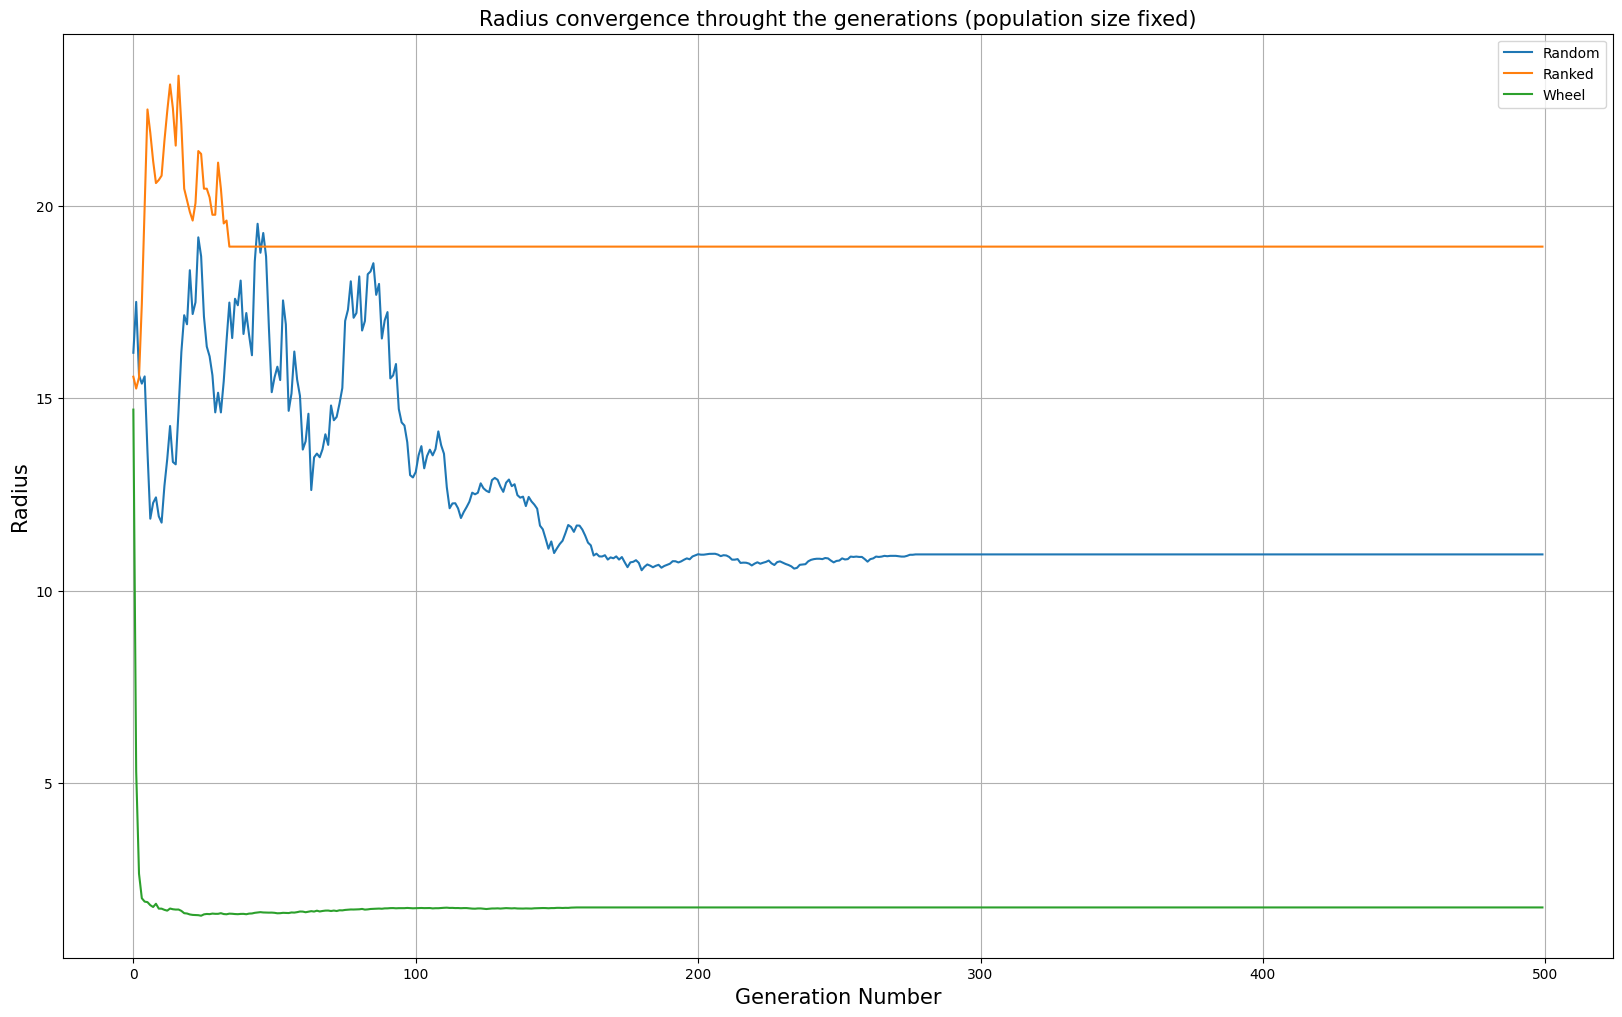

In [24]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()

plt.show()

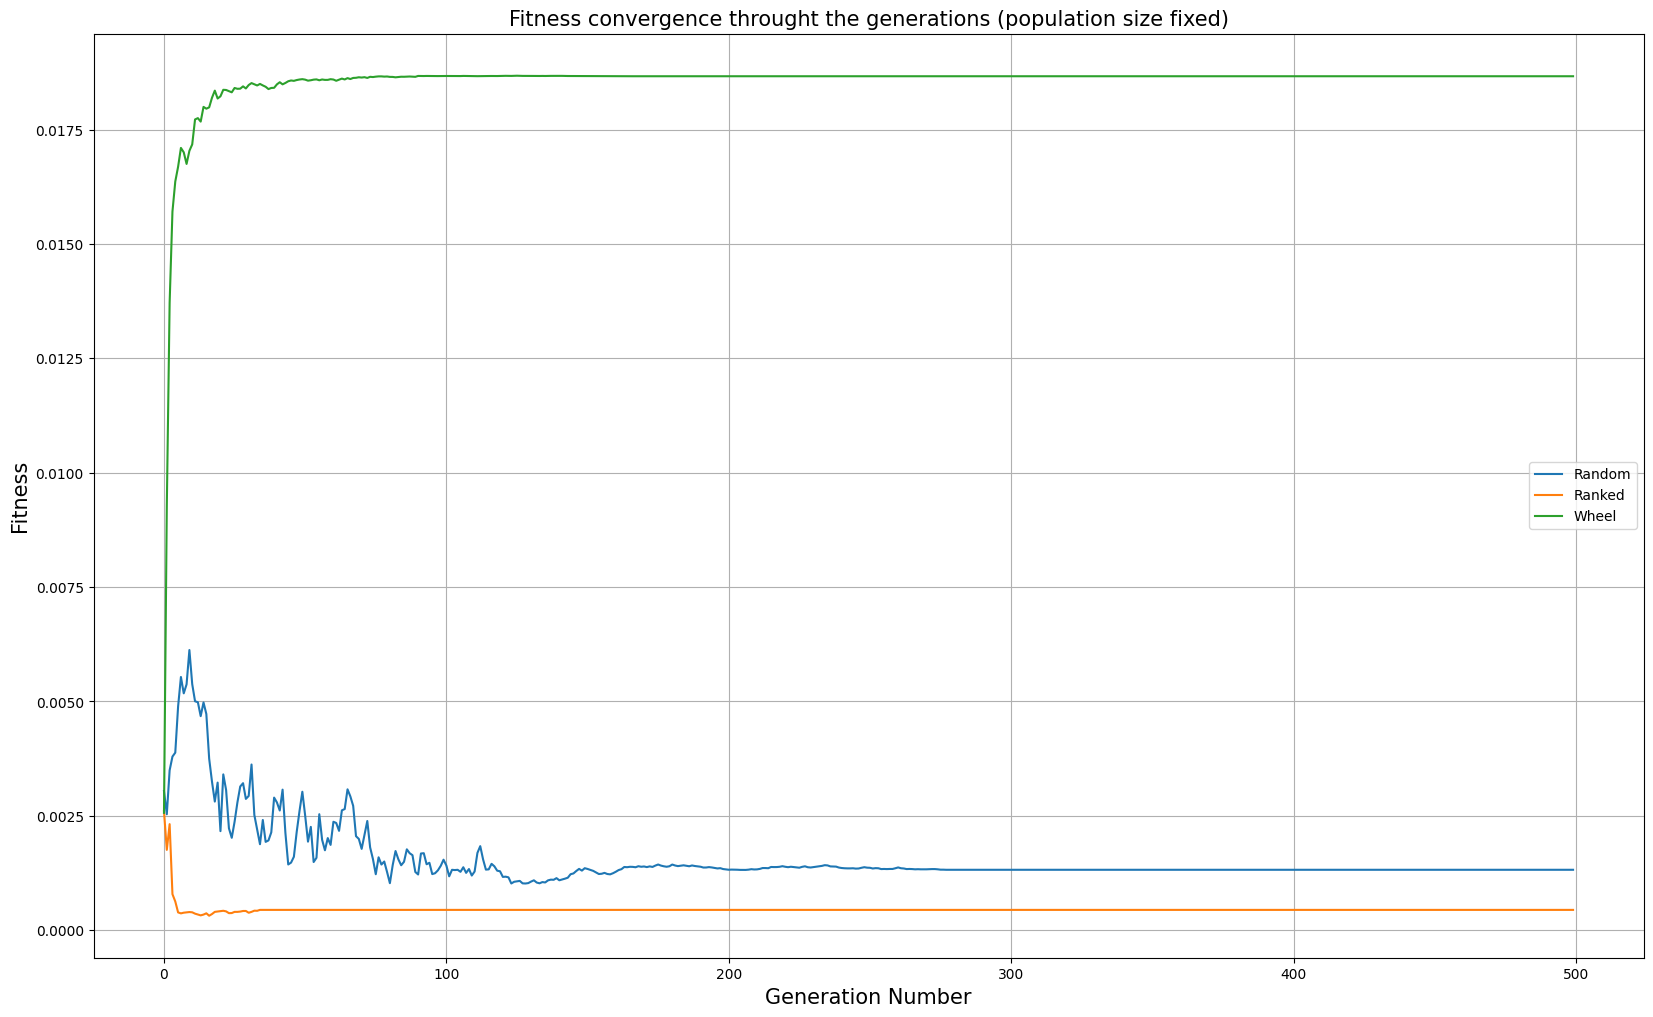

In [25]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()

plt.show()